# Data Wrangling with Pandas

A couple of simple examples using some of the powerful built in pandas functions.  The data is taken from a DraftFantasy.com league.

In [2]:
import urllib
from urllib.request import urlopen
import json
import pandas as pd
import numpy as np

## Data Retrieval

Retrieve data from a GraphQL endpoint.  There's no authentication/token required to query the endpoint, so we just need to know the correct query, which in this case is encoded as a single string.

Data is stored as a list of dicts, which a Pandas dataframe is created from.

In [3]:
base_url="https://draftfantasyfootball.co.uk/graphql"
gw=1
latest_gw=25
gw_data=[]
while gw <= latest_gw:
    try:
        d={"operationName":"getHeadToHeadMatches","variables":{"leagueId":"ABWkR4hBw4GWmSp8q","gameweek":gw},"query":"query getHeadToHeadMatches($leagueId: String!, $gameweek: Int!) {\n  headToHeadMatches(leagueId: $leagueId, gameweek: $gameweek) {\n    _id\n    gameweek\n    leagueId\n    team1 {\n      _id\n      name\n      liveGameweekPoints(gameweek: $gameweek)\n      user {\n        profile {\n          firstName\n          lastName\n          __typename\n        }\n        __typename\n      }\n      __typename\n    }\n    team2 {\n      _id\n      name\n      liveGameweekPoints(gameweek: $gameweek)\n      user {\n        profile {\n          firstName\n          lastName\n          __typename\n        }\n        __typename\n      }\n      __typename\n    }\n    __typename\n  }\n}\n"}
        hdr = {'content-type': 'application/json'}
        req = urllib.request.Request(base_url,headers=hdr, data=bytes(json.dumps(d), encoding="utf-8"))
        site_data = urlopen(req)
        data = json.load(site_data)
        gw_data+=data['data']['headToHeadMatches']
        gw+=1
    except Exception as e:
        print("error retrieving : {}".format(base_url))
        print(e)
        break

In [16]:
df = pd.DataFrame(gw_data)

In [17]:
df.head()

,__typename,_id,gameweek,leagueId,team1,team2
0,HeadToHeadMatch,2siym5Z2sFKN3a7hi,1,ABWkR4hBw4GWmSp8q,"{'__typename': 'Team', '_id': 'wbed7EjRC9T3n6x...",None
1,HeadToHeadMatch,jSPLCJCGJZ6A4BbFY,1,ABWkR4hBw4GWmSp8q,"{'__typename': 'Team', '_id': 'Y9s5ai5jTk2azRD...","{'__typename': 'Team', '_id': '6pn7hitEDGtRQmr..."
2,HeadToHeadMatch,oKGQCETdijgnspKhz,1,ABWkR4hBw4GWmSp8q,"{'__typename': 'Team', '_id': '6pdanoFD84n4zKL...","{'__typename': 'Team', '_id': 'rgF7P3CeNZP7cRt..."
3,HeadToHeadMatch,WrsPi6Nvoi5AYNMik,1,ABWkR4hBw4GWmSp8q,"{'__typename': 'Team', '_id': '7opskg8Tc6SfsXA...","{'__typename': 'Team', '_id': 'BBXHYEt6GPrZsNL..."
4,HeadToHeadMatch,dbwNpp4DcsfMGu6cJ,2,ABWkR4hBw4GWmSp8q,"{'__typename': 'Team', '_id': 'Y9s5ai5jTk2azRD...","{'__typename': 'Team', '_id': 'BBXHYEt6GPrZsNL..."


## Data Wrangling

The data is created from a hierarchical JSON format which is reflected in the data frame.  Team information is stored within a dict within the data frame.  The first thing we need to do is expand the dict and flatten the data.

Our observations are based around each team's gameweek, so that's what each row should reflect.

### Metling data

We want a single team colum.  The **melt** makes our dataframe 'less wide' i.e. unpivots our team1/team2 column and preserves the remaining columns.

We can then drop a bunch of columns that we're not interested in and expand the dict in the resuling 'value' column to the values that we're interested in 

In [19]:
df['match_id'] = df.index
df_1 = pd.melt(df, id_vars=["__typename", "_id", "gameweek","leagueId","match_id"], var_name="team")

In [20]:
df_2 = pd.concat([df_1.drop(['value','leagueId','team','__typename'], axis=1), df_1['value'].apply(pd.Series)], axis=1)
df_2.head(8)

,_id,gameweek,match_id,__typename,_id,liveGameweekPoints,name,user
0,2siym5Z2sFKN3a7hi,1,0,Team,wbed7EjRC9T3n6x9N,48.0,Carpet Munchers,"{'__typename': 'User', 'profile': {'__typename..."
1,jSPLCJCGJZ6A4BbFY,1,1,Team,Y9s5ai5jTk2azRDav,41.0,Draft Excluders,"{'__typename': 'User', 'profile': {'__typename..."
2,oKGQCETdijgnspKhz,1,2,Team,6pdanoFD84n4zKLXb,55.0,The Wrecking Balls,"{'__typename': 'User', 'profile': {'__typename..."
3,WrsPi6Nvoi5AYNMik,1,3,Team,7opskg8Tc6SfsXAnf,38.0,Dr Wankenstein,"{'__typename': 'User', 'profile': {'__typename..."
4,dbwNpp4DcsfMGu6cJ,2,4,Team,Y9s5ai5jTk2azRDav,40.0,Draft Excluders,"{'__typename': 'User', 'profile': {'__typename..."
5,aymJHZcdCvktJ7bF2,2,5,NaN,NaN,NaN,NaN,NaN
6,KYpEWb9SL2aYqyCdA,2,6,Team,wbed7EjRC9T3n6x9N,43.0,Carpet Munchers,"{'__typename': 'User', 'profile': {'__typename..."
7,RXeZMfSu9WHY55hKW,2,7,Team,6pdanoFD84n4zKLXb,43.0,The Wrecking Balls,"{'__typename': 'User', 'profile': {'__typename..."


### Handling Missing Average Data

The data we retrieved from the site is missing team information for the 'Average' team.  These need to be calculated and filled in.

The name is trivial, we can just use the built in **fillna** function on the name column.

Calculating the average score is slightly less obvious, but is a good opportunity to use the **transform** function. We call transform on our **groupby** object which which returns a NDFrame.  The method we call replaces the NaN in each group with the mean of the other values.

We want an int for our scope so **apply** np.round to the resulting score.

In [21]:
df_3 = df_2.drop(["_id","__typename","user"], axis=1).sort_values(by='match_id').reset_index(drop=True)
df_3[['name']] = df_3[['name']].fillna(value='Average')

In [22]:
df_3["liveGameweekPoints"] = df_3.groupby("gameweek")["liveGameweekPoints"].transform(lambda x: x.fillna((x.mean())))
df_3["liveGameweekPoints"] = df_3["liveGameweekPoints"].apply(np.round)

In [23]:
df_3.head()

,gameweek,match_id,liveGameweekPoints,name
0,1,0,48.0,Carpet Munchers
1,1,0,45.0,Average
2,1,1,41.0,Draft Excluders
3,1,1,40.0,Ben Foster on Draft
4,1,2,55.0,The Wrecking Balls


### Calculating Opponent Score and Resulting Points

We duplicate the gameweek points column and group by our "match_id" (i.e. the duplicate of the initial dataframe index).  We then want to reverse each grouped object and return a dataframe - this is what the **apply** and **reset_index** functions do.

We then **apply** the logic to calculate score i.e. 3 points for a win, 1 for a draw, 0 for a loss.

The rolling score for each week as calculated using the **cumsum** function.

In [25]:
df_4 = df_3
df_4['opponent_score'] = df_4['liveGameweekPoints']
df_4['opponent_score'] = df_4.groupby("match_id")['opponent_score'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)

In [26]:
df_4.head()

,gameweek,match_id,liveGameweekPoints,name,opponent_score
0,1,0,48.0,Carpet Munchers,45.0
1,1,0,45.0,Average,48.0
2,1,1,41.0,Draft Excluders,40.0
3,1,1,40.0,Ben Foster on Draft,41.0
4,1,2,55.0,The Wrecking Balls,50.0


In [27]:
df_5=df_4
df_4['score'] = df_4.apply(lambda x: 3 if x['liveGameweekPoints'] > x['opponent_score'] else 1 if x['liveGameweekPoints'] == x['opponent_score'] else 0, axis=1)

In [28]:
df_6=df_5
df_6['rolling_score']=df_6.groupby(by="name")['score'].cumsum()

In [29]:
df_6.tail()

,gameweek,match_id,liveGameweekPoints,name,opponent_score,score,rolling_score
195,25,97,51.0,RA Galaxy,32.0,3,45
196,25,98,41.0,Draft Excluders,25.0,3,54
197,25,98,25.0,The Wrecking Balls,41.0,0,33
198,25,99,38.0,Average,36.0,3,36
199,25,99,36.0,Carpet Munchers,38.0,0,27


## Flattening and Graphing the Data

Group by manager name and gameweek.  Expand the dataframe using the **unstack** function.

Finally plot the data into a graph.

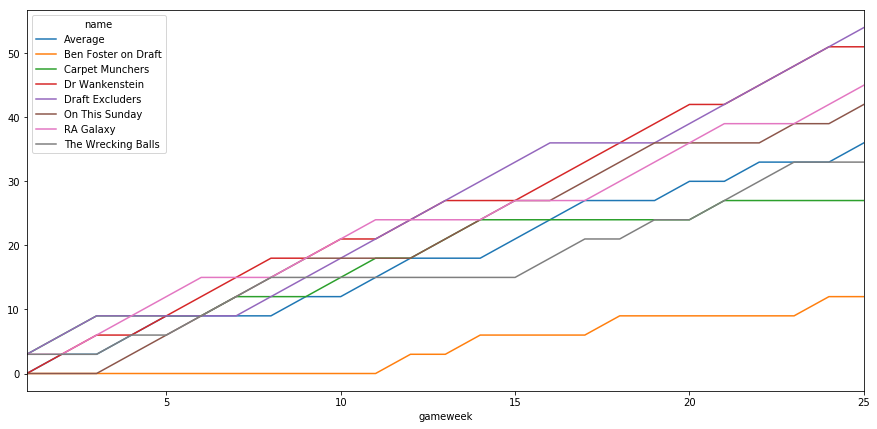

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df_7 = df_6.groupby(['gameweek','name']).first()['rolling_score'].unstack()
df_7.plot(ax=ax)

## Animate the graph

ToDo... watch this space.